# VARMA and Neural Networks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from matplotlib.colors import from_levels_and_colors, ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from scipy.stats import multivariate_normal, kurtosis
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


# for google code colab only
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 15000})'''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

# 1. Data Importing and Selection

In [ ]:
data = pd.read_csv('data1.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
data

,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,MSCI DENMARK,MSCI EM ASIA,MSCI EM EU-MIDE-AFRICA,MSCI EM EUROPE,MSCI EM LATIN AMERICA,MSCI FINLAND,MSCI FRANCE,MSCI GERMANY,MSCI HONG KONG,MSCI INDIA,MSCI ITALY,MSCI JAPAN,MSCI KOREA,MSCI MEXICO,MSCI NETHERLANDS,MSCI NEW ZEALAND,MSCI NORWAY,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,59.47,8566.71,403.66,210.209,244.42,1829.81,120.63,131.10,140.65,12080.11,987.16,61.26,938.40,526.86,5262.19,120.08,115.77,2373.17,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70
2016-01-08,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,54.63,8183.00,377.65,194.927,231.93,1674.47,115.86,122.85,129.12,11438.23,945.87,56.94,876.35,510.54,4757.80,112.38,113.67,2209.38,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88
2016-01-15,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,51.54,7755.73,363.18,181.941,217.90,1625.73,112.37,119.45,125.17,11063.73,927.24,54.86,849.09,500.01,4738.23,110.37,113.92,2095.60,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56
2016-01-22,1254.167,2281.98,2935.0677,985.87,95.79,100.73,879.17,1582.10,51.15,8035.69,363.10,185.011,221.47,1620.67,115.08,123.00,128.08,10654.83,919.19,54.36,833.57,501.70,4769.16,114.75,112.20,2173.55,745.96,367.44,1350.0500,1160.48,99.21,10469.07,1076.48,1719.61,1814.12
2016-01-29,1298.240,2462.19,3134.0840,1005.56,96.93,103.05,958.97,1638.84,52.13,8211.17,374.07,201.286,237.29,1744.05,116.55,125.61,128.32,11002.78,941.64,53.16,866.68,508.22,5083.75,117.19,112.43,2214.88,825.18,400.93,1375.1000,1239.58,100.06,10432.42,1087.17,1774.40,1843.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-25,988.345,1450.64,2252.2500,1166.97,84.95,64.63,1424.53,2018.62,94.77,11122.05,586.97,204.113,251.32,1851.40,129.40,137.63,140.60,13557.76,1314.60,48.90,987.02,713.98,3386.63,163.96,193.67,2570.43,1162.66,554.53,1328.1400,1238.65,78.45,14099.14,1362.07,1641.51,3191.72
2020-10-02,1037.211,1506.32,2265.7000,1128.45,84.89,66.00,1365.07,2031.76,97.19,11389.27,601.70,208.396,249.75,1817.40,131.19,140.51,143.29,13494.25,1354.23,49.52,972.54,726.69,3491.80,169.19,189.41,2587.30,1172.45,543.08,1344.0300,1276.25,79.97,14355.01,1368.78,1658.14,3243.91
2020-10-09,1075.670,1617.45,2214.3200,1187.29,90.01,69.35,1447.85,2076.53,101.03,11779.71,625.29,211.647,254.26,1923.79,134.39,144.34,147.24,13860.76,1400.51,50.76,995.55,746.72,3767.52,173.03,196.06,2635.08,1212.32,553.32,1358.9700,1291.47,82.44,14602.91,1375.90,1687.56,3370.62


# 2. Measuring Skewness

Preparation of log series, log return series For reference, data is the price series https://www.youtube.com/watch?v=d8MBpc3ST10

In [ ]:
data_log = np.log2(data)
data_logreturn = data_log.diff().dropna()

## 2.1 Calculate the skewness of each return series

Skewness defines whether data show any symmetry distribution, precisely, the lack of symmetry.

In [ ]:
data_logreturn_skew = data_logreturn.skew().rename('skew')
data_logreturn_skew

LUXXX                    -0.666695
MSCI ARGENTINA           -2.597766
BLP ORIENTE MEDIO        -0.883507
MSCI AUSTRALIA           -1.866552
MSCI AUSTRIA             -1.422148
MSCI BELGIUM             -2.203723
MSCI BRAZIL              -0.355652
MSCI CANADA              -2.811046
MSCI CHINA               -0.505233
MSCI DENMARK             -1.588630
MSCI EM ASIA             -0.735563
MSCI EM EU-MIDE-AFRICA   -1.318454
MSCI EM EUROPE           -2.077995
MSCI EM LATIN AMERICA    -0.987533
MSCI FINLAND             -2.220340
MSCI FRANCE              -2.194887
MSCI GERMANY             -2.060874
MSCI HONG KONG           -0.417641
MSCI INDIA               -0.580011
MSCI ITALY               -2.405344
MSCI JAPAN               -0.784169
MSCI KOREA               -0.968534
MSCI MEXICO              -1.089898
MSCI NETHERLANDS         -2.072041
MSCI NEW ZEALAND         -1.019529
MSCI NORWAY              -1.667430
MSCI PERU                -0.676029
MSCI RUSSIA              -1.528631
MSCI SINGAPORE      

## 2.2 Calculate the difference between the mean and the median for each series

In [ ]:
data_logreturn_mean = data_logreturn.mean().rename('mean')
data_logreturn_median = data_logreturn.median().rename('median')
mean_median = data_logreturn_mean - data_logreturn_median
mean_median

LUXXX                    -0.001801
MSCI ARGENTINA           -0.003883
BLP ORIENTE MEDIO        -0.002034
MSCI AUSTRALIA           -0.002547
MSCI AUSTRIA             -0.000995
MSCI BELGIUM             -0.003659
MSCI BRAZIL              -0.003960
MSCI CANADA              -0.002930
MSCI CHINA               -0.002996
MSCI DENMARK             -0.005335
MSCI EM ASIA             -0.001915
MSCI EM EU-MIDE-AFRICA   -0.002165
MSCI EM EUROPE           -0.003028
MSCI EM LATIN AMERICA    -0.004073
MSCI FINLAND             -0.001173
MSCI FRANCE              -0.003702
MSCI GERMANY             -0.003598
MSCI HONG KONG           -0.004382
MSCI INDIA               -0.004239
MSCI ITALY               -0.002092
MSCI JAPAN               -0.003165
MSCI KOREA               -0.001442
MSCI MEXICO               0.000986
MSCI NETHERLANDS         -0.003114
MSCI NEW ZEALAND         -0.002068
MSCI NORWAY              -0.002478
MSCI PERU                -0.003050
MSCI RUSSIA              -0.007424
MSCI SINGAPORE      

## 2.3 How do the skewness and the (mean-median) difference compare?

Skewness measures how symmetric data are. 
Negative values indicate that data are skewed left (i.e left tail of the distrubution is longer relative to the right tail) and positive values for the skewness indicate data that are skewed right.

Generally, if the distribution of data is skewed to the left, the mean is less than the median. If the distribution of data is skewed to the right, the median is less than the mean.

# 3. Structural Breaks and Kurtosis

Kurtosis shows the degree of peakedness of a distribution, in other words where peak is sharp and tails are 'thin'. Standard Normal distribution has a kurtosis = 3, where (kurtosis - 3) is referred as "excess kurtosis".

The positive "excess kurtosis" indicates a "heavy-tailed" distribution and negative kurtosis indicates a "light tailed" distribution.

## 3.1 Calculate the kurtosis for your response return series

In [ ]:
data_logreturn_kurtosis = data_logreturn.kurtosis().rename('kurtosis')
data_logreturn_kurtosis

LUXXX                      4.421429
MSCI ARGENTINA            17.891785
BLP ORIENTE MEDIO          9.349361
MSCI AUSTRALIA            10.022817
MSCI AUSTRIA              11.366770
MSCI BELGIUM              14.607653
MSCI BRAZIL                4.985534
MSCI CANADA               20.035133
MSCI CHINA                 0.632811
MSCI DENMARK               6.605505
MSCI EM ASIA               2.130922
MSCI EM EU-MIDE-AFRICA     8.229085
MSCI EM EUROPE            13.095029
MSCI EM LATIN AMERICA      7.252917
MSCI FINLAND              16.593619
MSCI FRANCE               16.931433
MSCI GERMANY              16.053511
MSCI HONG KONG             2.144171
MSCI INDIA                 6.840329
MSCI ITALY                18.705074
MSCI JAPAN                 6.238976
MSCI KOREA                 5.399236
MSCI MEXICO                5.144533
MSCI NETHERLANDS          13.057412
MSCI NEW ZEALAND           6.910370
MSCI NORWAY               10.047515
MSCI PERU                  5.883961
MSCI RUSSIA                8

## 3.2 Run a threshold regression model to identify at least 1 regime shift.

 In financial markets the prices can change abruptly, this is usually triggered by fundamental changes in macroeconomic variables, policies or regulations.
When trying to model financial prices, we can see that the mean, variance and correlation patterns of stocks can vary dramatically.

Regime shift models helps to solve this issue.

> The idea here is that time series exists in two or more states, each 
characterized by their own probability distributions, and the transition of one state to another is governed by another process or variable.




We will pick ETF 'MSCI UK' for regime shift model testing

In [ ]:
np.random.seed(42)
msci_uk_logreturn = pd.DataFrame(data_logreturn['MSCI UK'])
msci_uk = data['MSCI UK']

In [ ]:
model = MarkovRegression( msci_uk_logreturn,  k_regimes=2,  switching_variance=True)
model_results = model.fit()
print(model_results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                MSCI UK   No. Observations:                  251
Model:               MarkovRegression   Log Likelihood                 548.564
Date:                Mon, 18 Jan 2021   AIC                          -1085.128
Time:                        20:48:30   BIC                          -1063.975
Sample:                    01-08-2016   HQIC                         -1076.616
                         - 10-23-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.618      0.537      -0.002       0.004
sigma2         0.0005   7.83e-05      5.849      0.0

In [ ]:
regime0_prob = model_results.smoothed_marginal_probabilities[0]
regime1_prob = model_results.smoothed_marginal_probabilities[1]
regime1_active = regime1_prob > regime0_prob 

## 3.3 Calculate the standard deviation of the return series for each regime.

We can see that regime0 is suitable for low volatility on the market; while regime1 identifies high volatility times. 

In [ ]:
msci_uk_regime0 = msci_uk_logreturn.loc[ regime0_prob >= 0.5 ]
msci_uk_regime1 = msci_uk_logreturn.loc[ regime1_prob > 0.5 ]
msci_uk_regime0_std = msci_uk_regime0.std()
msci_uk_regime1_std = msci_uk_regime1.std()
print('Standard deviation for regime0=%.5f' % msci_uk_regime0_std )
print('Standard deviation for regime1=%.5f' % msci_uk_regime1_std )

Standard deviation for regime0=0.02177
Standard deviation for regime1=0.08561


## 3.4 Fit a Bivariate Normal Distribution BN(mean1, standard deviation1, mean2, standard deviation2, mixing parameter).  For simplicity, you can assume the means are the same.

We will arbitrary pick 'MSCI GERMANY' to build bivariate normal distribution 

In [ ]:
msci_germany_logreturn = data_logreturn['MSCI GERMANY']
msci_uk_logreturn = data_logreturn['MSCI UK']
msci_germany = data['MSCI GERMANY']

Lets have a look at histograms of returns to check visually if log returns for selected ETFs (MSCI Germany, MSCI UK) are symmetric

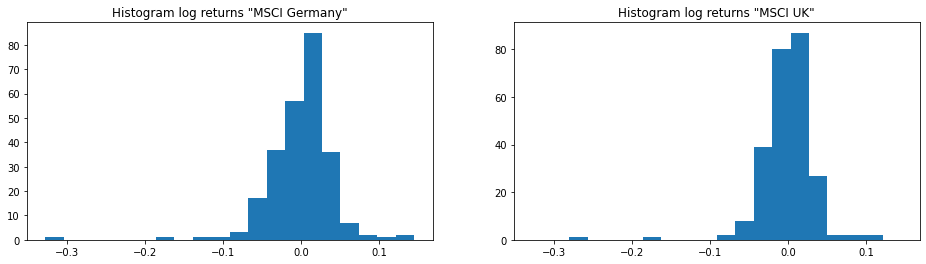

In [ ]:
xmin = min( np.amin(msci_germany_logreturn), np.amin(msci_uk_logreturn))
xmax = max( np.amax(msci_germany_logreturn), np.amax(msci_uk_logreturn))
arange = (xmin , xmax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.hist(msci_germany_logreturn, range=arange, bins=20)
ax1.set_title('Histogram log returns "MSCI Germany"')

ax2.hist(msci_uk_logreturn, range=arange, bins=20)
ax2.set_title('Histogram log returns "MSCI UK"')
plt.show()

Now we plot bivariate normal distribution based on log returns of selected ETFs

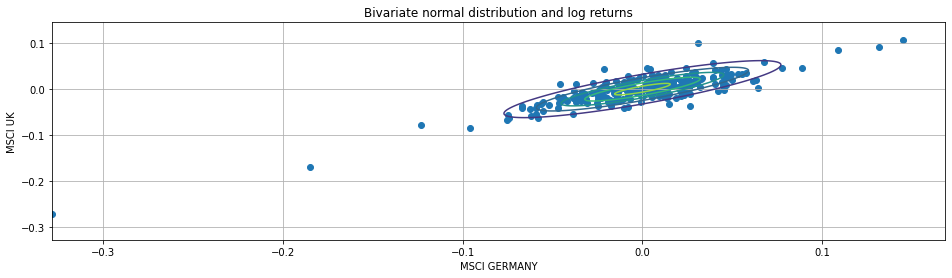

In [ ]:
x1 = msci_germany_logreturn
x2 = msci_uk_logreturn

#calculate the covariance matrix
mean_values = [x1.mean(), x2.mean()]
data = np.stack(( x1, x2 ), axis=0)
covariance_matrix = np.cov(data)

model = multivariate_normal(cov=covariance_matrix, mean=mean_values)
x, y = np.mgrid[xmin:xmax:.001, xmin:xmax:.001]
pos = np.dstack((x, y))

fix, ax = plt.subplots(figsize=(16,4))
ax.scatter(x1, x2)
ax.contour(x, y, model.pdf(pos), levels=5)
ax.set_title('Bivariate normal distribution and log returns')
ax.set_xlabel('MSCI GERMANY')
ax.set_ylabel('MSCI UK')
ax.grid()
plt.show()

## 3.5 Calculate the kurtosis for your response return series

In [ ]:
regime0_kurtosis = kurtosis(msci_uk_regime0)
regime1_kurtosis = kurtosis(msci_uk_regime1)
print('Kurtosis for regime0=%.5f' % regime0_kurtosis )
print('Kurtosis for regime1=%.5f' % regime1_kurtosis )


Kurtosis for regime0=0.22195
Kurtosis for regime1=1.72071


# 4. Visualizing Distributions

## 4.1 Use your response variable that you ran a regime shift model.  Show the following graphs in side-by-side panels.  Keep the scales of the 2 graphs the same!

Let's plot regime and prices to identify dates and market events when regime switch happens

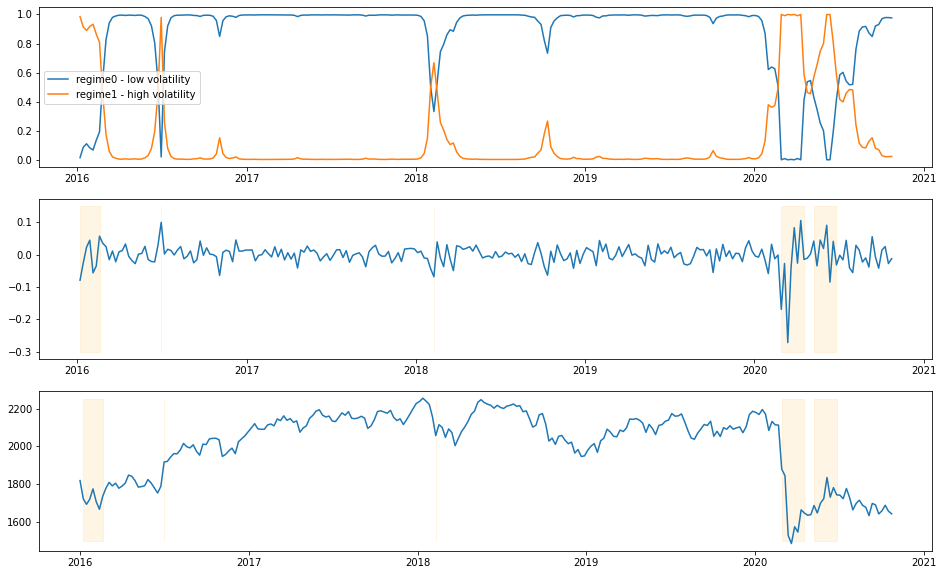

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,10))
ax1.plot(regime0_prob, label="regime0 - low volatility")
ax1.plot(regime1_prob, label="regime1 - high volatility")
ax1.legend()

ax2.plot(msci_uk_logreturn)
ax2.fill_between(msci_uk_logreturn.index, -0.3, 0.15, where=regime1_active, color='orange', alpha=0.1)

ax3.plot(msci_uk)
ax3.fill_between(msci_uk_logreturn.index, 1500, 2250, where=regime1_active, color='orange', alpha=0.1)

plt.show()

## 4.2 Plot histograms for each return series.  Superimpose a density plot on top.

<IPython.core.display.Javascript object>

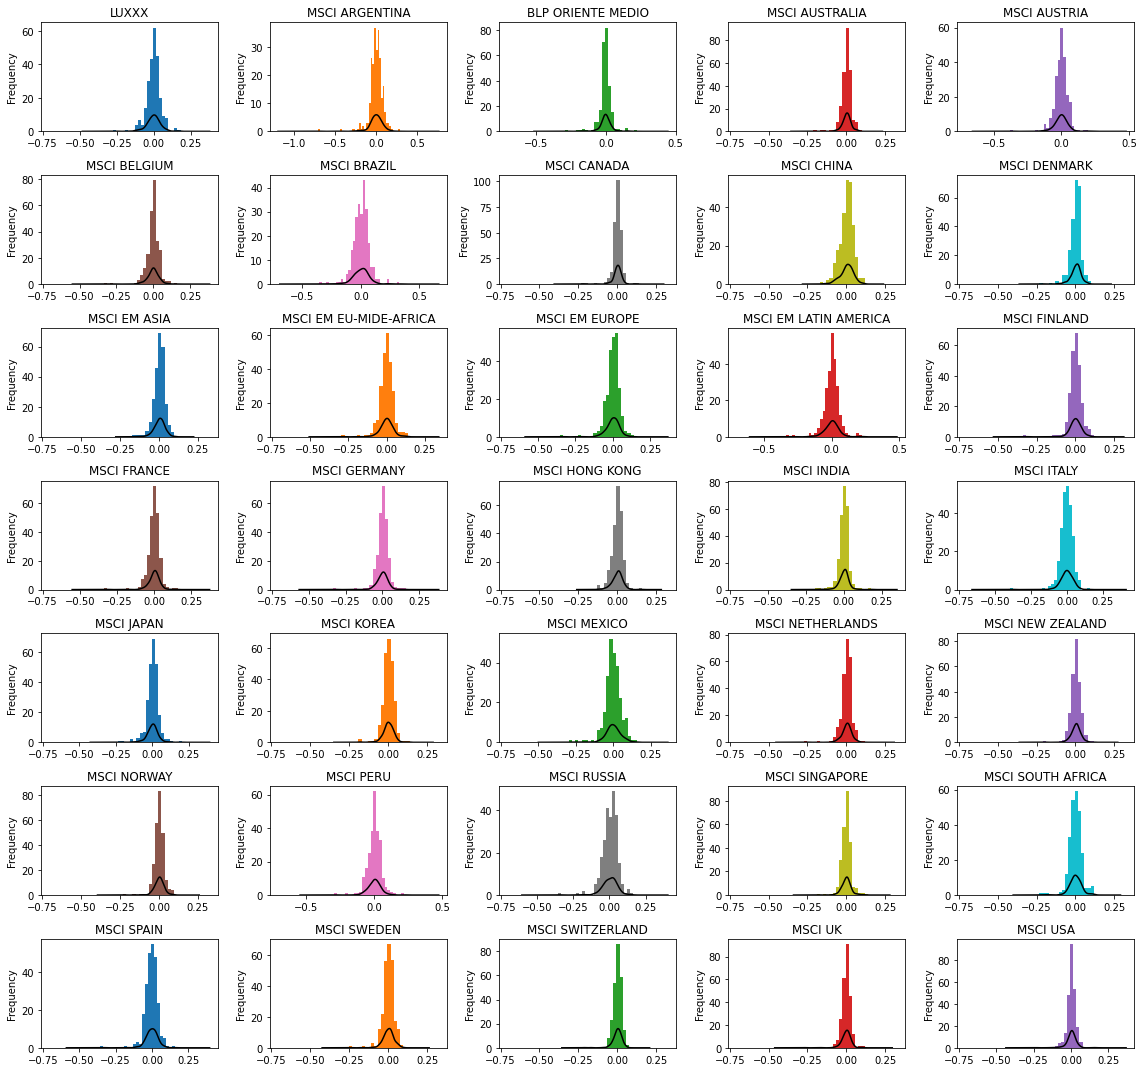

In [ ]:
# len(data_logreturn.columns) = 35
NUM_ROWS = 7
NUM_COLS = 5
fig, axes = plt.subplots(NUM_ROWS,NUM_COLS,figsize=(16,15))

data_logreturn.plot(kind='density', color='black', subplots=True, 
              ax=axes, title=list(data_logreturn.columns), legend=None)

data_logreturn.plot(kind='hist', bins=50, subplots=True, ax=axes, legend=None)
fig.tight_layout()

# for google code colab only
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

## 4.3 Plot a qqplot for each return series.  Superimpose the points on the plot

<IPython.core.display.Javascript object>

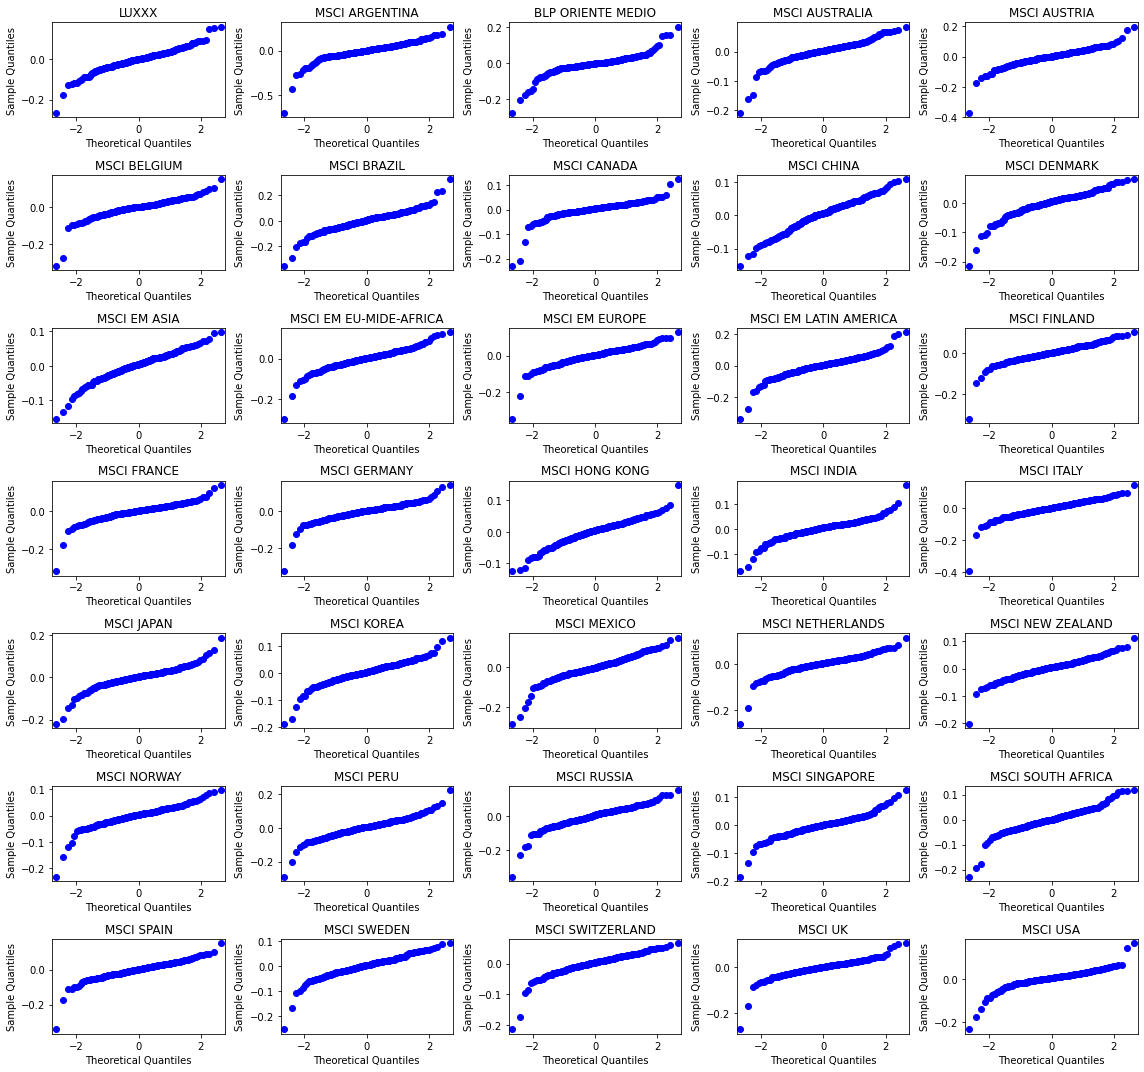

In [ ]:
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS,figsize=(16,15))

idx = 0
for column in data_logreturn.columns:
  row = (int)(np.floor(idx / NUM_COLS))
  col = (int)(idx % NUM_COLS)
  ax = axes[row][col]
  sm.qqplot(data_logreturn[column], ax = ax)
  ax.set_title(column)
  idx = idx + 1
  
fig.tight_layout()

# for google code colab only
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# 5. Outliers

Anything that is unusual and deviates from the standard “normal” is called an Anomaly or an Outlier.

## 5.1 Using a combination of calculated stats and visuals, identify the outliers.

Let's find anomalies as described on https://medium.com/analytics-vidhya/how-anomaly-detection-works-4651f1786431

In [ ]:
x1 = msci_germany_logreturn
x2 = msci_uk_logreturn

#calculate the covariance matrix
mean_values = [x1.mean(), x2.mean()]
data = np.stack(( x1, x2 ), axis=0)
covariance_matrix = np.cov(data)

model = multivariate_normal(cov=covariance_matrix, mean=mean_values)
data = np.stack((x1,x2),axis=1)

#finding the outliers
threshold = 1.0e-5
outlier = model.pdf(data).reshape(-1) < threshold

for flag,i in enumerate(outlier):
  if i == True:
    print(data[flag]," is an Outlier")

[-0.32833426 -0.27196887]  is an Outlier


Looks like anomaly appears in the left bottom corner, let's plot it.

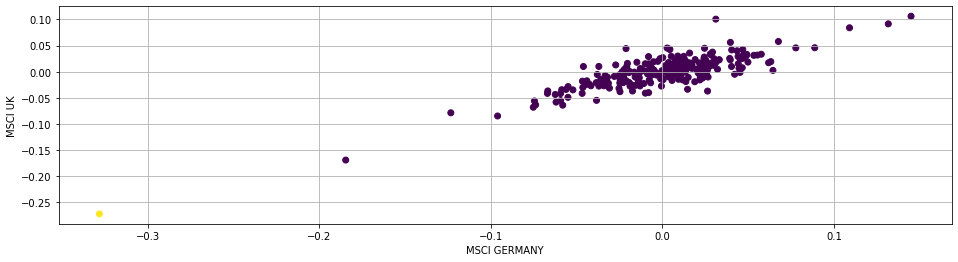

In [ ]:
fix, ax = plt.subplots(figsize=(16,4))
ax.scatter(x1, x2, c=outlier)
ax.set_xlabel('MSCI GERMANY')
ax.set_ylabel('MSCI UK')
ax.grid()

## 5.2 What is a monotone transformation?

Montonic function is a function $f(x)$ whose increments $Δf(x) = f(x′) − f(x)$ do not change sign when $Δx = x′ − x > 0$; that is, the increments are either always nonnegative or always nonpositive.

A monotonicity condition can hold either for all x or for x on a given interval 



## 5.3 Is there a monotone transformation of the data that can help handle the outliers better?  If so, perform it.

Taking log is an often-used monotone transformation. Since we already have log returns. We can also normalize the series further.

[0.73791607 2.98780779]  is an Outlier
[-4.39098019 -4.97557809]  is an Outlier
[-7.80432789 -8.01964774]  is an Outlier


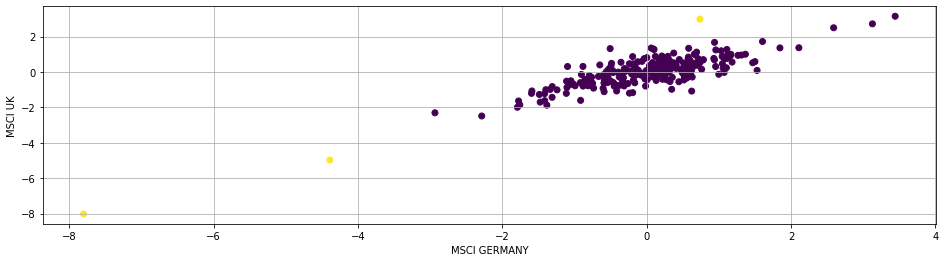

In [ ]:
# Normalizing the series (twice for optimal effect)

def normalize(x):
  x_mean = x.mean()
  x_std =  x.std()
  return (x-x_mean) / x_std

x1new = normalize(x1)
x2new = normalize(x2)

# Same procedure as above
mean_values = [x1new.mean(), x2new.mean()]
data = np.stack(( x1new, x2new ), axis=0)
covariance_matrix = np.cov(data)

model = multivariate_normal(cov=covariance_matrix, mean=mean_values)
data = np.stack((x1new,x2new),axis=1)

#finding the outliers
threshold = 1.0e-5
outlier = model.pdf(data).reshape(-1) < threshold

for flag,i in enumerate(outlier):
  if i == True:
    print(data[flag]," is an Outlier")
fix, ax = plt.subplots(figsize=(16,4))
ax.scatter(x1new, x2new, c=outlier)
ax.set_xlabel('MSCI GERMANY')
ax.set_ylabel('MSCI UK')
ax.grid()

# 6. Compare unsupervised and supervised methods of learning

Unsupervised learning is a technique, where model discover information, patterns it self without any additional information - 'labelling'.
Supervise learning technique the model is trained to produce expected results also called 'labels'.

Supervised learning:

* produces data base on previous expirience ( train dataset)
* allows to optimize perfomanace criteria based on expectaions
* provides highly accurate and trustworthy results compared to unsupervised learning.
* regression and classification are main techniques

Unsupervised learning

*   the technique allows to find unknown patterns in data _(could be false-positive)_
*   allows to identify features which for categorization which are not known in advance.
*   does not require any information _(labelling)_ about analysed data.
*   clustering and association are main techniques for unspervised learning




## 6.1 Is the neural network methodology supervised or unsupervised?  Explain.

The learning algorithm of a neural network can either be supervised or unsupervised. 
A neural net is said to learn supervised, if the desired output is already known,
otherwise it learns unsupervised

# 7. Vector Auto-Regressive Moving Average (VARMA)

Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)

## 7.1 Run a VARMA model, which models your response (e.g. LUXXX) versus lagged versions of itself AND with some number of exogeneous variables (e.g. the other ETFs). Use the variables you chose from your LASSO regression (see GWP#1). 

In [ ]:
msci_uk = pd.DataFrame(data_logreturn['MSCI UK'])
all_other_indexes = pd.DataFrame(data_logreturn.drop(columns=['MSCI UK']))

X_train, X_test, y_train, y_test = train_test_split(all_other_indexes.to_numpy(), 
                                                    msci_uk.to_numpy(), 
                                                    test_size=0.33, 
                                                    random_state=0)

lasso = Lasso(alpha=0.00015)
lasso.fit(X_train, y_train)
selected_etfs = data_logreturn.columns[:-1][lasso.coef_ > 0.001]
selected_etfs

Index(['MSCI ARGENTINA', 'MSCI BELGIUM', 'MSCI BRAZIL',
       'MSCI EM EU-MIDE-AFRICA', 'MSCI FINLAND', 'MSCI FRANCE', 'MSCI MEXICO',
       'MSCI NORWAY', 'MSCI RUSSIA', 'MSCI SOUTH AFRICA', 'MSCI SWITZERLAND'],
      dtype='object')

Let's have a look how many lags we might need for auto-regression

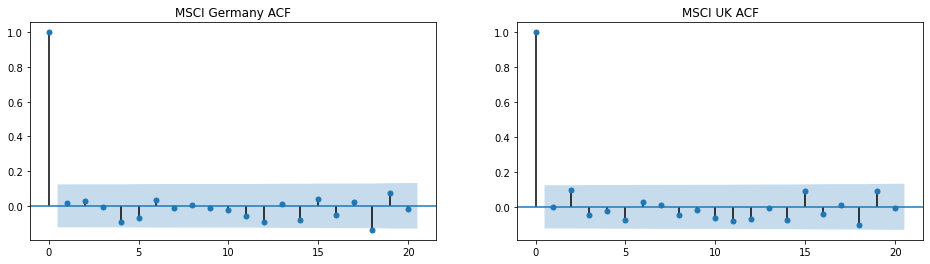

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
sm.graphics.tsa.plot_acf(data_logreturn['MSCI GERMANY'], lags=20, 
                         title='MSCI Germany ACF', ax=ax1)
sm.graphics.tsa.plot_acf(data_logreturn['MSCI UK'], lags=20,
                         title='MSCI UK ACF', ax = ax2)
plt.show()

In [ ]:
endog = data_logreturn[['MSCI UK', 'MSCI GERMANY']]
exog = data_logreturn[selected_etfs]
varmax = sm.tsa.VARMAX(endog=endog, exog=exog, order=(1,0))
varmax_model = varmax.fit()
print(varmax_model.summary())

# for google code colab only
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


                                Statespace Model Results                               
Dep. Variable:     ['MSCI UK', 'MSCI GERMANY']   No. Observations:                  251
Model:                                 VARX(1)   Log Likelihood                1454.381
                                   + intercept   AIC                          -2846.763
Date:                         Mon, 18 Jan 2021   BIC                          -2737.473
Time:                                 20:48:52   HQIC                         -2802.782
Sample:                             01-08-2016                                         
                                  - 10-23-2020                                         
Covariance Type:                           opg                                         
Ljung-Box (Q):                47.51, 30.96   Jarque-Bera (JB):         2.20, 221.65
Prob(Q):                        0.19, 0.85   Prob(JB):                   0.33, 0.00
Heteroskedasticity (H):         0.93, 0.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<IPython.core.display.Javascript object>

## 7.2 What is the difference between how we ran LASSO (GWP #1) and the VARMA?  (Hint: think about time subscripts)

The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model. The VARMA model is based on :

*  AR(p) - an autoregressive model is when a value from a time series is regressed on previous values from that same time series.
*  MA(q) - the moving average method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps

LASSO is based on shrinkage, ie. where data values are shrunk towards a central point, like the mean.

In other words VARMA models the value based on previous time series values while LASSO assumes indepndence of time series values (i.e the order of time series does not change LASSO path).

## 7.3 Find a different set of variables that works BETTER than the original LASSO regression.  Show a statistical measure to justify its improved performance.

In [ ]:
msci_uk_logreturn_predicted = varmax_model.predict()['MSCI UK']
mean_error = np.mean((msci_uk_logreturn_predicted - msci_uk_logreturn)**2)
print('Prediction root mean squared error ', np.sqrt(mean_error))
print('Regression: R^2 score on test set', 
      r2_score(msci_uk_logreturn, msci_uk_logreturn_predicted)*100)


Prediction root mean squared error  0.014459543700927365
Regression: R^2 score on test set 81.66891200313535


In [ ]:
varmax = sm.tsa.VARMAX(endog=endog, exog=exog, order=(1,5), trend='ct')
varmax_model = varmax.fit()

print('-------------------------')

msci_uk_logreturn_predicted = varmax_model.predict()['MSCI UK']
mean_error = np.mean((msci_uk_logreturn_predicted - msci_uk_logreturn)**2)
print('Prediction root mean squared error ', np.sqrt(mean_error))
print('Regression: R^2 score on test set', 
       r2_score(msci_uk_logreturn, msci_uk_logreturn_predicted)*100)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-------------------------
Prediction root mean squared error  0.013727357354949747
Regression: R^2 score on test set 83.47836798511833


# 8. Neural Networks

## 8.1 Perform a Neural Network, where the response is categorical: whether your return was higher or lower than the previous week.  (Ties can be ignored).  Choose a suitable number of layers, basing your result on cross-validation

First of all we define categories 1-'UP'/0-'DOWN' for weekly changes in log returns for MSCI UK.

In [ ]:
msci_uk = pd.DataFrame(data_logreturn['MSCI UK'])
msci_uk_updown = pd.DataFrame(msci_uk.gt(msci_uk.shift()) * 1)
all_other_indexes = pd.DataFrame(data_logreturn.drop(columns=['MSCI UK']))

Prepare training sets

In [ ]:
nn_x_train, nn_x_test, nn_y_train, nn_y_test = train_test_split(all_other_indexes, 
                                                    msci_uk_updown,
                                                    test_size = 0.33,
                                                    shuffle = False)

Now we define model to build neural network, whith output layer as sigmoid as more suitable for classification tasks. Dropout layer will try to cover previousl values of returns

In [ ]:
def build_nn_model(num_of_hidden_layers, num_of_neurons):
    def bm():
        model = Sequential()
        for layer in range(0, num_of_hidden_layers):
          model.add(
              Dense(num_of_neurons, kernel_initializer='normal', activation='relu'))
        # output layer is linear
        model.add(Dropout(0.8))
        model.add( Dense( units = 1, activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return bm

Run cross-validation validation with kfold to calcualte different number of neurons

In [ ]:
num_of_layers = 5
num_of_neurons = 34
model_scores = {}

for layers in range(1, num_of_layers):
    estimator = KerasClassifier(
        build_fn=build_nn_model(layers, num_of_neurons), 
        epochs=20, batch_size=5, verbose=0)
    
    # use kfold with split 5
    results = cross_validate(estimator, nn_x_test, nn_y_test, cv=5)['test_score']
    model_scores[ layers ] = results.mean()

nn_model_layers = pd.Series(model_scores).idxmax()
print("Classificationm model test scores for different layers:", model_scores)
print("Classification num of layers:", nn_model_layers)

Classificationm model test scores for different layers: {1: 0.7242647171020508, 2: 0.7360294222831726, 3: 0.79558824300766, 4: 0.7602941274642945}
Classification num of layers: 3


In [ ]:
model_nn = build_nn_model(nn_model_layers, num_of_neurons)()
model_nn.fit(nn_x_train, nn_y_train)
None

6/6 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5616


## 8.2 Run a Regression Neural Network.  The difference here is the response is continuous.  This value should be the weekly return that you calculated on each series. Choose a suitable number of layers, basing your result on cross-validation

In [ ]:
msci_uk = pd.DataFrame(data_logreturn['MSCI UK'])
all_other_indexes = pd.DataFrame(data_logreturn.drop(columns=['MSCI UK']))

rr_x_train, rr_x_test, rr_y_train, rr_y_test = train_test_split(all_other_indexes, 
                                                    msci_uk,
                                                    test_size = 0.33,
                                                    shuffle = False)

Now we define a model with custom number of layers and neurons, while output layer has linear value

In [ ]:
def build_regression_model(num_of_hidden_layers, num_of_neurons):
    def bm():
        model = Sequential()
        # there must at least one layer
        for layer in range(1, num_of_hidden_layers):
          model.add(Dense(num_of_neurons, kernel_initializer='normal', activation='relu'))
        # output layer is linear
        model.add( Dense( units = 1, activation = 'linear'))
        model.compile(loss='mean_absolute_error', optimizer='adam')
        return model
    return bm


We use KerasRegressor to estimate models with differen number of hidden layers

In [ ]:
num_of_layers = 5
num_of_neurons = 17
model_scores = {}

for layers in range(1, num_of_layers):
    estimator = KerasRegressor(
        build_fn=build_regression_model(layers, num_of_neurons), 
        epochs=20, batch_size=5, verbose=0)
    
    # use kfold with split 5
    results = cross_validate(estimator, rr_x_test, rr_y_test, cv=5)['test_score']
    model_scores[ layers ] = results.mean()

rr_model_layers = pd.Series(model_scores).idxmax()
print("Model test scroes for different layers:", model_scores)
print("Num of layers:", rr_model_layers)

Model test scroes for different layers: {1: -0.029251956194639207, 2: -0.014771139807999134, 3: -0.015800618566572666, 4: -0.018045050092041492}
Num of layers: 2


Let's build a model to use it in section 8.3

In [ ]:
model_rr = build_regression_model(rr_model_layers, num_of_neurons)()
model_rr.fit(rr_x_train, rr_y_train)
None

6/6 [==============================] - 0s 2ms/step - loss: 0.0183


## 8.3 Which performed better, the classification or the regression network?

We will compare regression and classification networks by $R^2$ of the predictions

In [ ]:
model_rr_score = r2_score (rr_y_test, model_rr.predict(rr_x_test)) 
model_nn_score = r2_score (nn_y_test, model_nn.predict(nn_x_test)) 

print("Regregression r^2 = %.2f " % model_rr_score)
print("Classification r^2 = %.2f " % model_nn_score)
print("VARMA r^2 = %.2f" % r2_score(msci_uk_logreturn, msci_uk_logreturn_predicted))

Regregression r^2 = 0.50 
Classification r^2 = 0.00 
VARMA r^2 = 0.83


In [ ]:
len(msci_uk)

251

Judging from r^2 alone, VARMA provided the best fit. The classification network model we used to built UP/DOWN of log returns can't predict the values - a r^2 score of 0 suggests that it is outputting the same response regardless of input variables. 

A possible reason for the underperformance of NN in such scenarios can be related to the lack of data. Neural nets, even with 2-3 layers, on a dataset of only length 250 data points, usually does not have enough data to train properly. 

In addition, for simplicity we had taken the simple cross_validation provided but in a time series, we should only use walkforward cross validation in order to prevent time leakage. This could have caused us to overfit on the training datasets and hence resulted in the low performance.